In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl
from transit import SimpleSystem

/home/dfm/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/home/dfm/anaconda/lib/python2.7/site-packages/astropy/config/configuration.py:682: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:Could not find unix home directory to search for astropy config dir on None
  warn(ConfigurationMissingWarning(msg))


In [54]:
campaign = 3
# epicid = "201367065"
# epicid = "201912552"
epicid = "206475757"
basepath = "/export/bbq2/dfm/k2/web"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    invert=True,
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=2179.0,
    skip=0,
    durations=[0.05, 0.1],
    min_period=0.5,
    max_period=10.,
    npeaks=3,
    mask_frac=1.0,
    # injections=[dict(period=5.275, t0=0.45, radius=0.07, b=0.5, q1=0.5, q2=0.5, e=0.01, pomega=0.0)],
)

In [55]:
pipe = ketu.k2.Data(cache=False)
# pipe = ketu.k2.Inject(pipe, cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True)
pipe = ketu.Vetter(pipe, cache=True, clobber=True)
pipe = ketu.FeatureExtract(pipe, cache=True, clobber=True)

In [56]:
r = pipe.query(**query)

Querying Data
Finished querying Data in 0.67s
Querying Likelihood
tau = 17.2849121094
tau = 17.2849121094
tau = 17.2849121094
Finished querying Likelihood in 21.38s
Querying OneDSearch
Finished querying OneDSearch in 92.65s
Querying IterativeTwoDSearch
Finished querying IterativeTwoDSearch in 65.50s
Querying Vetter
Finished querying Vetter in 10.97s
Querying FeatureExtract
Finished querying FeatureExtract in 0.00s


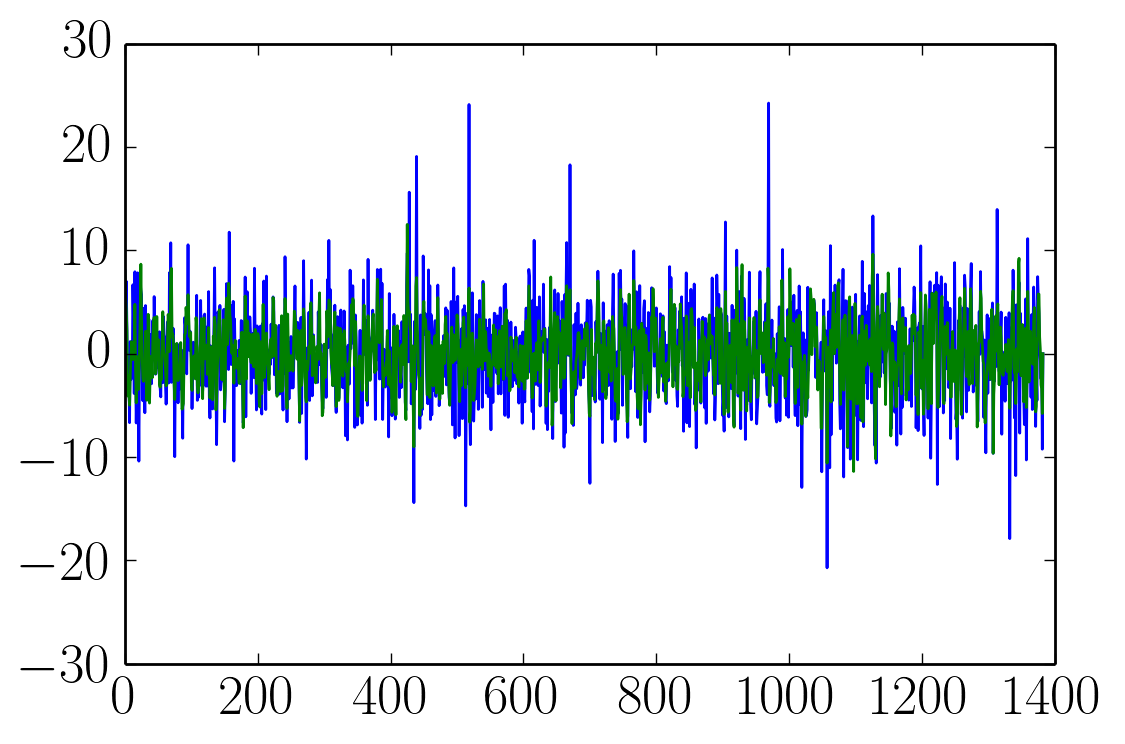

In [57]:
pl.plot(r.depth_1d)

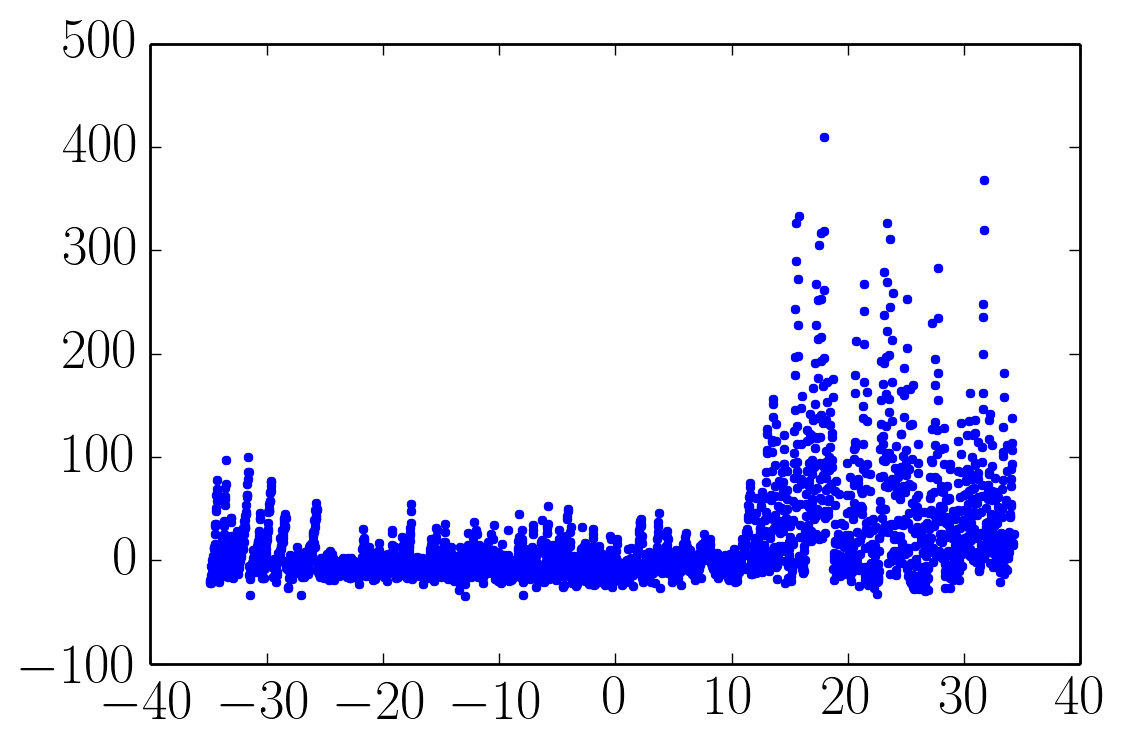

In [58]:
lcs = r.model_light_curves
[pl.plot(lc.time, lc.flux, ".") for lc in lcs];

In [59]:
r.peaks

[{'depth': 3.7836929862496143,
  'depth_ivar': 1.6399944041357675,
  'duration': 0.1,
  'lnZ_box': -1398.2592309285649,
  'lnZ_none': -1406.230018571036,
  'lnZ_outlier': -1399.9385670550919,
  'lnZ_transit': -1405.0739727686482,
  'lnZ_vee': -1399.1977538082731,
  'lnlike_box': -1399.0642233636945,
  'lnlike_none': -1406.230018571036,
  'lnlike_outlier': -1402.7930874316376,
  'lnlike_transit': -1398.6097175582127,
  'lnlike_vee': -1400.5485383800692,
  'period': 3.6057487939448341,
  'phic_same': -2023.2078551271009,
  'phic_same_second': -2028.8096008187733,
  'phic_variable': -38220.049967697705,
  's2n': 4.8454829867646225,
  't0': 0.77527430175349865,
  'transit_b': 0.52561515479367016,
  'transit_duration': 0.076570055880605198,
  'transit_period': 3.6075077730892486,
  'transit_q1': 0.50186224630359966,
  'transit_q2': 0.50017929589809196,
  'transit_ror': 0.060689657229991235,
  'transit_t0': 0.7688065847037352},
 {'depth': 2.0699256974655573,
  'depth_ivar': 4.937300430847622

(-0.17752255786642757, 1.8224774421335725)

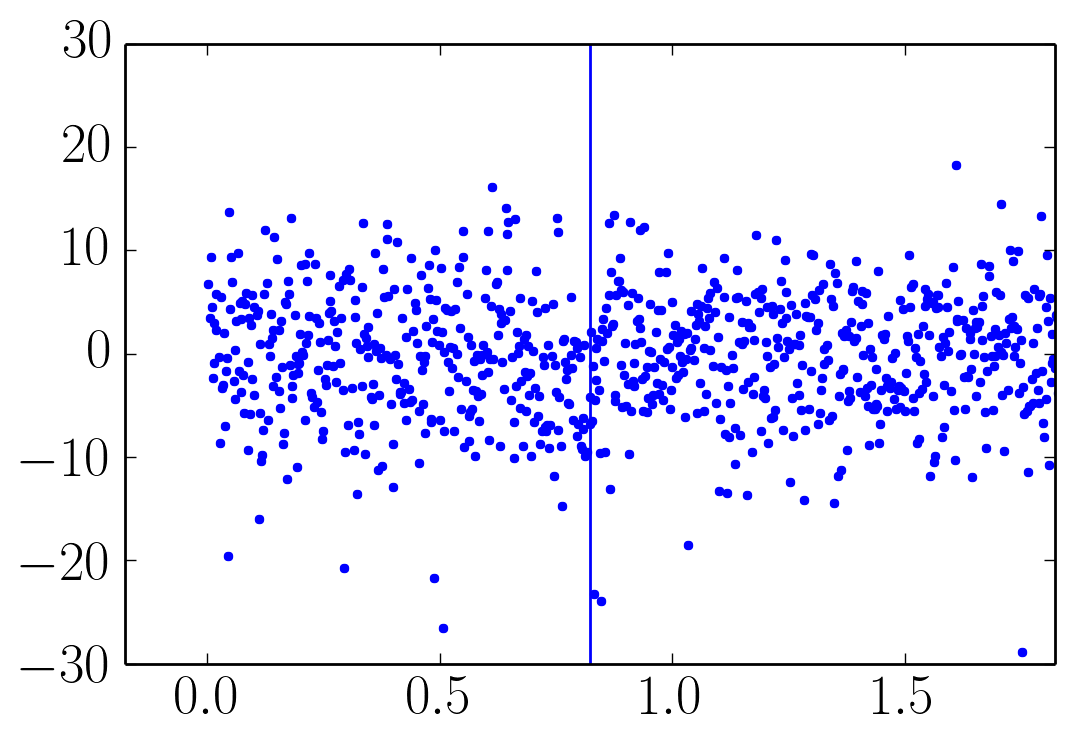

In [65]:
p = r.peaks[2]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

mod = [1e3*(s.light_curve(lc.time)-1.0) for lc in lcs]
[pl.plot(lc.time %  p["transit_period"], lc.flux - lc.predict(lc.flux - m), ".") for lc, m in zip(lcs, mod)]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-1, p["transit_t0"]+1)